In [28]:
import os
import librosa
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense, Dropout, Reshape, BatchNormalization, SpatialDropout2D, Masking
from tensorflow.keras.optimizers import RMSprop, Adam 
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')
import gc
from tensorflow.keras.models import load_model
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [ ]:
max_pad_len = 174
n_mfcc = 40  

In [ ]:
class MFCCDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_dir, batch_size=32, shuffle=True, augment=False, noise_factor=0.005):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.noise_factor = noise_factor
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.idx_to_class = {i: cls_name for i, cls_name in enumerate(self.classes)}
        self.file_paths = self._load_file_paths()
        self.on_epoch_end()
        self.num_classes = len(self.classes)

    def _load_file_paths(self):
        file_paths = []
        for class_name in self.classes:
            class_dir = os.path.join(self.data_dir, class_name)
            for mfcc_file in os.listdir(class_dir):
                if mfcc_file.endswith('.csv'):
                    file_paths.append((os.path.join(class_dir, mfcc_file), self.class_to_idx[class_name]))
        return file_paths

    def __len__(self):
        return int(np.floor(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_files = [self.file_paths[k] for k in indexes]
        X, y = self._data_generation(batch_files)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.file_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def _data_generation(self, batch_files):
        X = np.empty((self.batch_size, n_mfcc, max_pad_len)) 
        y = np.empty((self.batch_size), dtype=int)

        for i, (file_path, label) in enumerate(batch_files):
            mfcc_features = np.loadtxt(file_path, delimiter=',')

            if mfcc_features.shape[1] < max_pad_len:
                pad_width = max_pad_len - mfcc_features.shape[1]
                mfcc_features = np.pad(mfcc_features, pad_width=((0, 0), (0, pad_width)), mode='constant')
            elif mfcc_features.shape[1] > max_pad_len:
                mfcc_features = mfcc_features[:, :max_pad_len]

            if self.augment and random.random() < 0.5:
                noise = np.random.normal(loc=0, scale=self.noise_factor, size=mfcc_features.shape)
                mfcc_features = mfcc_features + noise
                mfcc_features = np.clip(mfcc_features, mfcc_features.min(), mfcc_features.max())

            X[i,] = mfcc_features
            y[i] = label

        return X.transpose(0, 2, 1)[..., np.newaxis], tf.keras.utils.to_categorical(y, num_classes=self.num_classes)

In [6]:
def create_cnn_lstm_model(input_shape=(max_pad_len, n_mfcc, 1), num_classes=10):
    model = Sequential([
        # First Conv Block
        Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        SpatialDropout2D(0.25),
        MaxPooling2D((2, 2)),

        # Second Conv Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        SpatialDropout2D(0.25),
        MaxPooling2D((2, 2)),

        # Third Conv Block
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        SpatialDropout2D(0.25),
        MaxPooling2D((2, 2)),

        # Reshape for TimeDistributed LSTM
        # Perhitungan reshape tetap sama karena input shape tetap (max_pad_len, n_mfcc, 1)
        Reshape((input_shape[0] // 8, (input_shape[1] // 8) * 256)),

        Masking(mask_value=0.), # Mask padded zeros

        # LSTM Layer
        LSTM(128, return_sequences=True),
        Dropout(0.3),

        LSTM(64),
        Dropout(0.3),

        # Dense Layers
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [10]:
input_root_mfcc = "matriks-mfcc-40koef" 
train_dir = os.path.join(input_root_mfcc, 'train')
val_dir = os.path.join(input_root_mfcc, 'validation')
test_dir = os.path.join(input_root_mfcc, 'test')

In [11]:
train_generator = MFCCDataGenerator(train_dir, batch_size=32, shuffle=True, augment=True, noise_factor=0.005)
validation_generator = MFCCDataGenerator(val_dir, batch_size=32, shuffle=False, augment=False)
test_generator = MFCCDataGenerator(test_dir, batch_size=32, shuffle=False, augment=False)

In [12]:
num_classes = train_generator.num_classes

In [14]:
cnn_lstm_model = create_cnn_lstm_model(
    input_shape=(max_pad_len, n_mfcc, 1), 
    num_classes=num_classes
)

In [15]:
cnn_lstm_model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [16]:
cnn_lstm_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 174, 40, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 174, 40, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_9             │ (None, 174, 40, 64)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 87, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 87, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 87, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_10            │ (None, 87, 20, 128)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 43, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 43, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 43, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_11            │ (None, 43, 10, 256)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 21, 5, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 21, 1280)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masking_3 (Masking)             │ (None, 21, 1280)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 21, 128)        │       721,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,146,692 (4.37 MB)

 Trainable params: 1,145,796 (4.37 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=10, 
    min_lr=0.00001, 
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=20, 
    restore_best_weights=True, 
    verbose=1
)

checkpoint_filepath = 'best_cnn_lstm_model.keras'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

print("Starting model training...")

history = cnn_lstm_model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stopping, model_checkpoint_callback]
)

print("Training finished.")

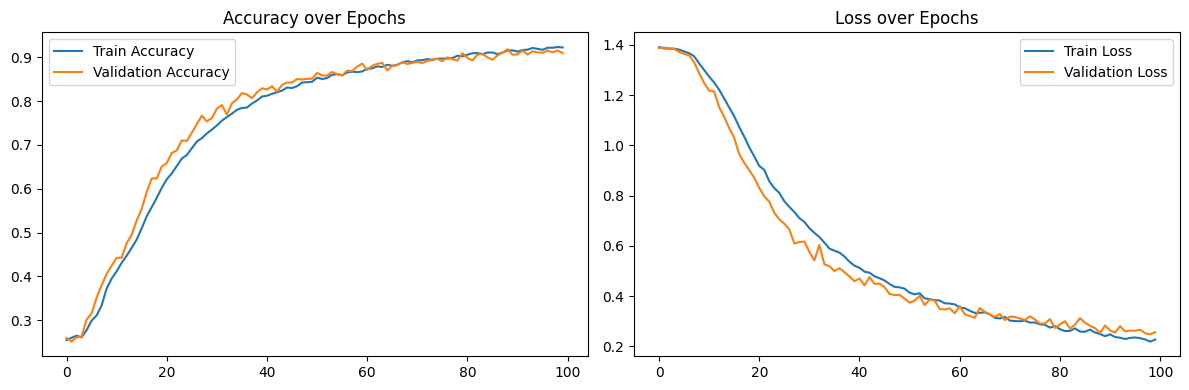

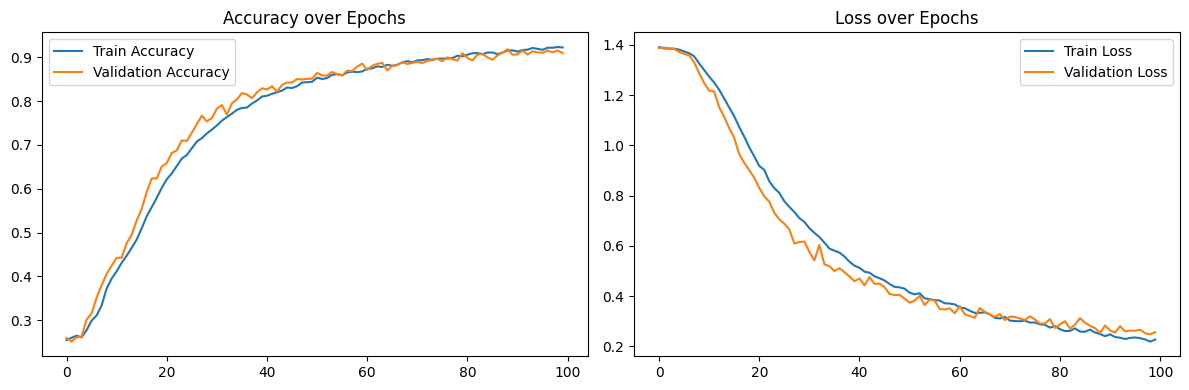

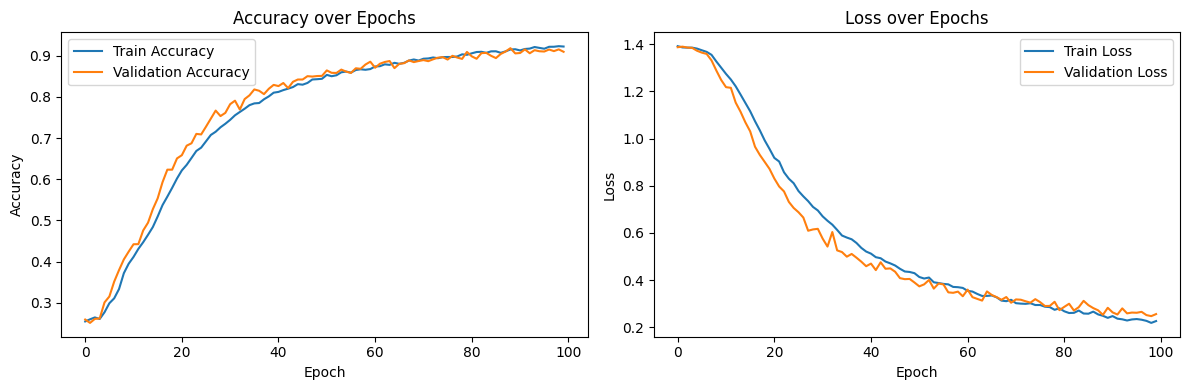

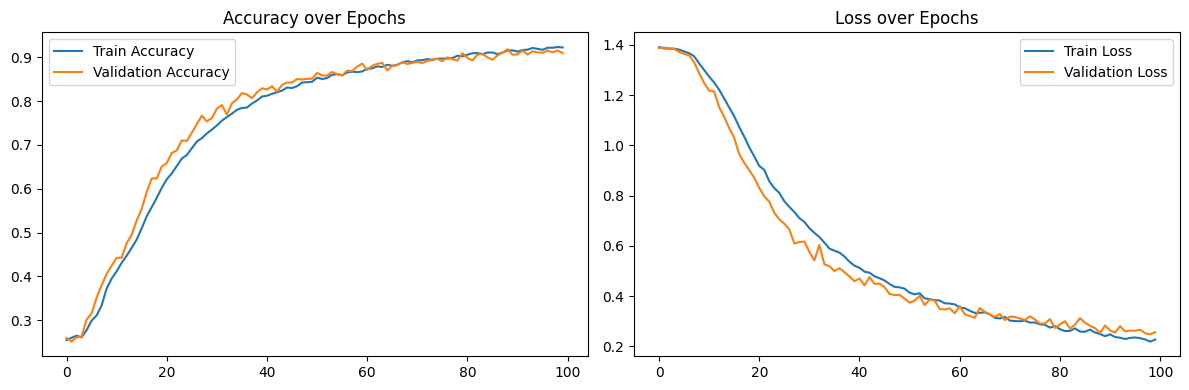

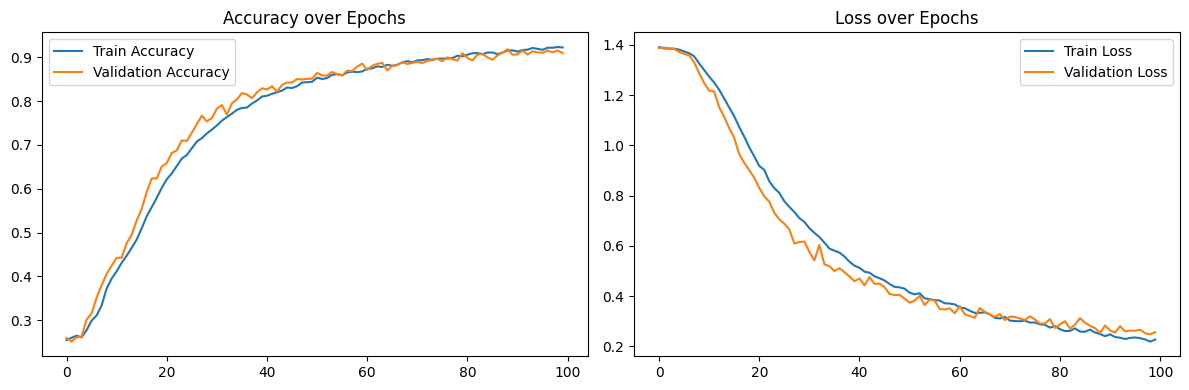

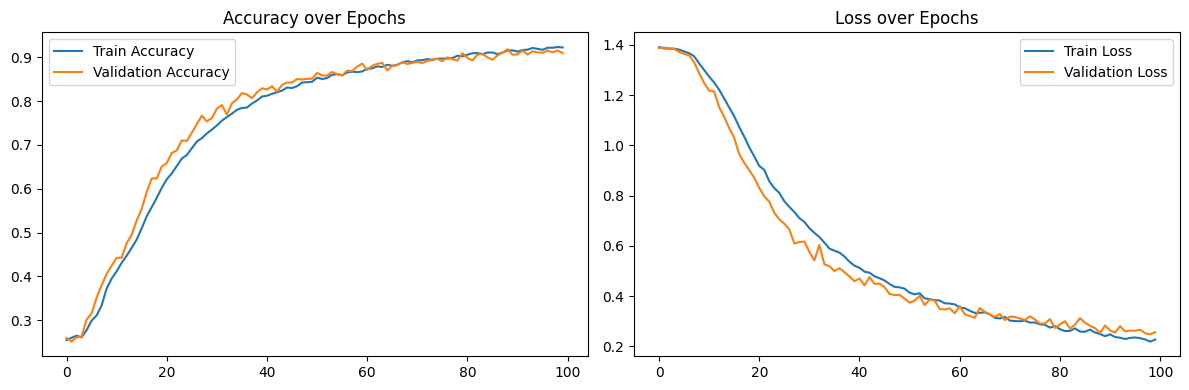

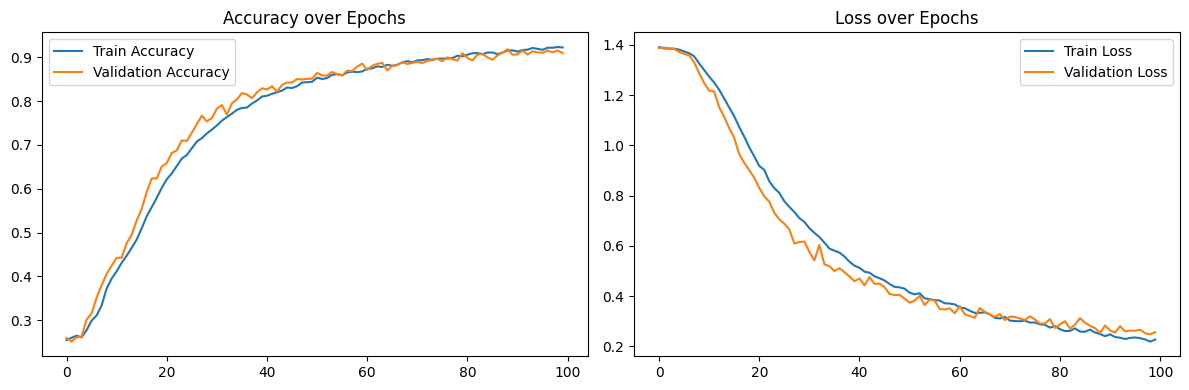

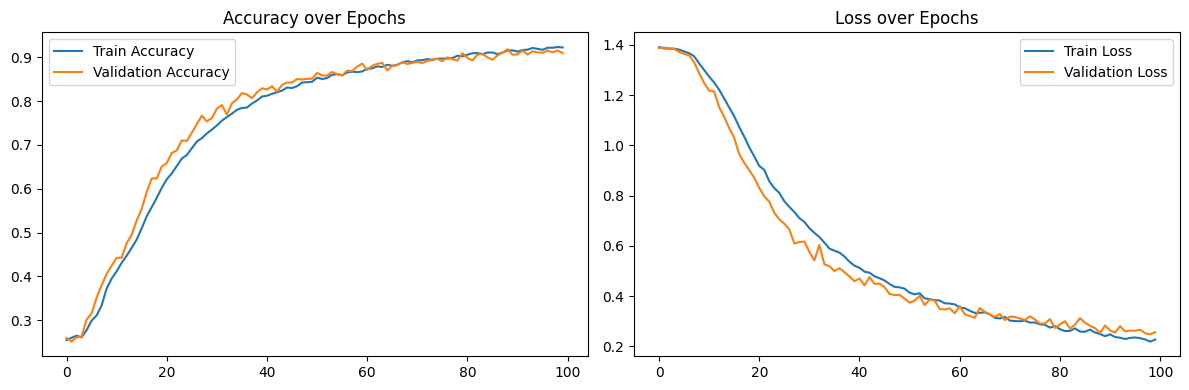

In [24]:
%matplotlib inline

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.tight_layout()
plt.show()


In [25]:
print(f"\nLoading best model from {checkpoint_filepath} for final evaluation.")
best_cnn_lstm_model = load_model(checkpoint_filepath)

print("\nEvaluating best model on test set:")
loss, accuracy = best_cnn_lstm_model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Loading best model from best_cnn_lstm_model.keras for final evaluation.

Evaluating best model on test set:
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 0.8998 - loss: 0.2819
Test Loss: 0.2964
Test Accuracy: 0.8971



Loading best model from best_cnn_lstm_model.keras for final evaluation.

Evaluating best model on test set:
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.8998 - loss: 0.2819
Test Loss: 0.2964
Test Accuracy: 0.8971


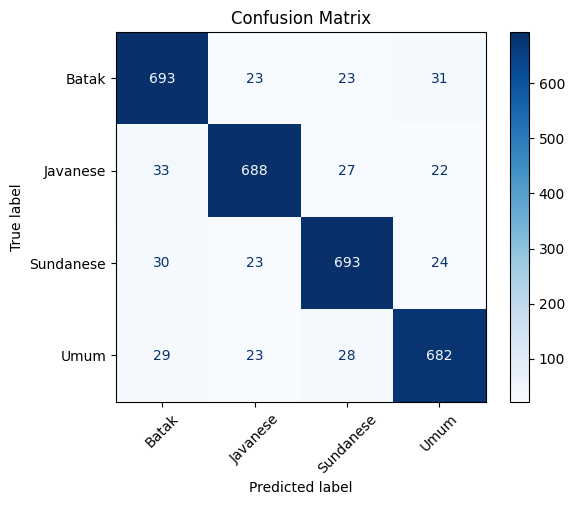


Classification Report:
              precision    recall  f1-score   support

       Batak     0.8828    0.9000    0.8913       770
    Javanese     0.9089    0.8935    0.9011       770
   Sundanese     0.8988    0.9000    0.8994       770
        Umum     0.8986    0.8950    0.8968       762

    accuracy                         0.8971      3072
   macro avg     0.8973    0.8971    0.8972      3072
weighted avg     0.8973    0.8971    0.8972      3072



In [ ]:
checkpoint_filepath = "best_cnn_lstm_model.keras"

print(f"\nLoading best model from {checkpoint_filepath} for final evaluation.")
best_cnn_lstm_model = load_model(checkpoint_filepath)

print("\nEvaluating best model on test set:")
loss, accuracy = best_cnn_lstm_model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

y_true = []
y_pred = []

for i in range(len(test_generator)):
    X_batch, y_batch = test_generator[i]
    preds = best_cnn_lstm_model.predict(X_batch, verbose=0)

    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_labels = ['Batak', 'Javanese', 'Sundanese', 'Umum']

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
print("\nClassification Report:")
print(report)


In [1]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# --- Configuration (These should match your training setup) ---
max_pad_len = 174  # The fixed length you padded/truncated MFCCs to during training
n_mfcc = 40        # The number of MFCC coefficients extracted

# Define the class labels in the same order as your model's output
# Based on your classification report, the order is Batak, Javanese, Sundanese, Umum.
class_labels = ['Batak', 'Javanese', 'Sundanese', 'Umum']

# Create a mapping from index to class name for easy interpretation of predictions
idx_to_class = {i: label for i, label in enumerate(class_labels)}

# --- Load the trained model ---
try:
    # Ensure this path is correct and the model file exists
    model_path = 'best_cnn_lstm_model.keras'
    best_cnn_lstm_model = load_model(model_path)
    print(f"Model loaded successfully from {model_path}.")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please ensure 'best_cnn_lstm_model.keras' is in the same directory or provide its full path.")
    exit() # Exit if the model cannot be loaded

# --- Prediction Function ---
def predict_accent_from_audio(audio_file_path, model, max_pad_len, n_mfcc, idx_to_class):
    """
    Predicts the accent from a given audio file using a trained CNN-LSTM model.

    Args:
        audio_file_path (str): The full path to the WAV audio file.
        model (tf.keras.Model): The loaded and trained Keras CNN-LSTM model.
        max_pad_len (int): The maximum padding length used for MFCC features during training.
        n_mfcc (int): The number of MFCC coefficients.
        idx_to_class (dict): A dictionary mapping numerical class indices to accent names.

    Returns:
        str: The predicted accent label, or an error message if processing fails.
    """
    try:
        # 1. Load the audio file
        y, sr = librosa.load(audio_file_path, sr=None)

        # 2. Extract MFCC features
        mfcc_features = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

        # 3. Pad or truncate MFCC features to the expected length
        if mfcc_features.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfcc_features.shape[1]
            mfcc_features = np.pad(mfcc_features, pad_width=((0, 0), (0, pad_width)), mode='constant')
        elif mfcc_features.shape[1] > max_pad_len:
            mfcc_features = mfcc_features[:, :max_pad_len]
        
        # Ensure the number of MFCCs is consistent (n_mfcc rows)
        if mfcc_features.shape[0] != n_mfcc:
            return f"Error: MFCC features shape mismatch. Expected {n_mfcc} rows, got {mfcc_features.shape[0]}."

        # 4. Reshape for model input: (batch_size, timesteps, features, channels)
        # Your model's input_shape is (max_pad_len, n_mfcc, 1).
        # The MFCC features extracted are typically (n_mfcc, timesteps).
        # So we transpose to (timesteps, n_mfcc) and add the batch and channel dimensions.
        processed_features = mfcc_features.transpose(1, 0)
        processed_features = processed_features[np.newaxis, ..., np.newaxis] # Adds batch_size and channel dimension

        # 5. Make a prediction
        predictions = model.predict(processed_features, verbose=0)
        
        # 6. Interpret the prediction
        predicted_class_idx = np.argmax(predictions, axis=1)[0]
        predicted_accent = idx_to_class[predicted_class_idx]
        confidence = np.max(predictions) # Get the confidence score

        return f"Predicted Accent: {predicted_accent} (Confidence: {confidence:.4f})"

    except FileNotFoundError:
        return f"Error: Audio file not found at '{audio_file_path}'."
    except Exception as e:
        return f"An error occurred during prediction: {e}"

# --- Example Usage ---
if __name__ == "__main__":
    # --- IMPORTANT: Replace with the actual path to your audio file ---
    # Example for a test file from your structure:
    # Make sure to provide a .wav file that corresponds to one of your training accents.
    audio_file_path_to_check = r'D:\UNIVERSITAS PERTAMINA\Semester 6\ML\MFCC_accent-classification\dataset-sound\Umum\Ind013_M_U_C_news_0459.wav'
    # For example: 'matriks-mfcc-40koef/test/Batak/some_batak_audio.wav'

    if os.path.exists(audio_file_path_to_check):
        prediction_result = predict_accent_from_audio(audio_file_path_to_check, best_cnn_lstm_model, max_pad_len, n_mfcc, idx_to_class)
        print(prediction_result)
    else:
        print(f"Error: The specified audio file does not exist at '{audio_file_path_to_check}'.")
        print("Please update 'audio_file_path_to_check' with a valid path to your audio file.")

Model loaded successfully from best_cnn_lstm_model.keras.
Predicted Accent: Umum (Confidence: 0.9745)


In [ ]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# --- Configuration (These should match your training setup) ---
max_pad_len = 174  # The fixed length you padded/truncated MFCCs to during training
n_mfcc = 40        # The number of MFCC coefficients extracted

# Define the class labels in the same order as your model's output
# Based on your classification report, the order is Batak, Javanese, Sundanese, Umum.
class_labels = ['Batak', 'Javanese', 'Sundanese', 'Umum']

# Create a mapping from index to class name for easy interpretation of predictions
idx_to_class = {i: label for i, label in enumerate(class_labels)}

# --- Load the trained model ---
try:
    # Ensure this path is correct and the model file exists
    model_path = 'best_cnn_lstm_model.keras'
    best_cnn_lstm_model = load_model(model_path)
    print(f"Model loaded successfully from {model_path}.")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please ensure 'best_cnn_lstm_model.keras' is in the same directory or provide its full path.")
    exit() # Exit if the model cannot be loaded

# --- Prediction Function ---
def predict_accent_from_audio(audio_file_path, model, max_pad_len, n_mfcc, idx_to_class):
    """
    Predicts the accent from a given audio file using a trained CNN-LSTM model.

    Args:
        audio_file_path (str): The full path to the WAV audio file.
        model (tf.keras.Model): The loaded and trained Keras CNN-LSTM model.
        max_pad_len (int): The maximum padding length used for MFCC features during training.
        n_mfcc (int): The number of MFCC coefficients.
        idx_to_class (dict): A dictionary mapping numerical class indices to accent names.

    Returns:
        str: The predicted accent label, or an error message if processing fails.
    """
    try:
        # 1. Load the audio file
        y, sr = librosa.load(audio_file_path, sr=None)

        # 2. Extract MFCC features
        mfcc_features = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

        # 3. Pad or truncate MFCC features to the expected length
        if mfcc_features.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfcc_features.shape[1]
            mfcc_features = np.pad(mfcc_features, pad_width=((0, 0), (0, pad_width)), mode='constant')
        elif mfcc_features.shape[1] > max_pad_len:
            mfcc_features = mfcc_features[:, :max_pad_len]
        
        # Ensure the number of MFCCs is consistent (n_mfcc rows)
        if mfcc_features.shape[0] != n_mfcc:
            return f"Error: MFCC features shape mismatch. Expected {n_mfcc} rows, got {mfcc_features.shape[0]}."

        # 4. Reshape for model input: (batch_size, timesteps, features, channels)
        # Your model's input_shape is (max_pad_len, n_mfcc, 1).
        # The MFCC features extracted are typically (n_mfcc, timesteps).
        # So we transpose to (timesteps, n_mfcc) and add the batch and channel dimensions.
        processed_features = mfcc_features.transpose(1, 0)
        processed_features = processed_features[np.newaxis, ..., np.newaxis] # Adds batch_size and channel dimension

        # 5. Make a prediction
        predictions = model.predict(processed_features, verbose=0)
        
        predicted_class_idx = np.argmax(predictions, axis=1)[0]
        predicted_accent = idx_to_class[predicted_class_idx]
        confidence = np.max(predictions) 

        return f"Predicted Accent: {predicted_accent} (Confidence: {confidence:.4f})"

    except FileNotFoundError:
        return f"Error: Audio file not found at '{audio_file_path}'."
    except Exception as e:
        return f"An error occurred during prediction: {e}"

if __name__ == "__main__":
    audio_file_path_to_check = r'D:\UNIVERSITAS PERTAMINA\Semester 6\ML\MFCC_accent-classification\dataset-sound\Sundanese\Ind005_F_S_C_news_0164.wav'

    if os.path.exists(audio_file_path_to_check):
        prediction_result = predict_accent_from_audio(audio_file_path_to_check, best_cnn_lstm_model, max_pad_len, n_mfcc, idx_to_class)
        print(prediction_result)
    else:
        print(f"Error: The specified audio file does not exist at '{audio_file_path_to_check}'.")
        print("Please update 'audio_file_path_to_check' with a valid path to your audio file.")

Model loaded successfully from best_cnn_lstm_model.keras.
Predicted Accent: Sundanese (Confidence: 0.9452)


In [36]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# --- Configuration (These should match your training setup) ---
max_pad_len = 174  # The fixed length you padded/truncated MFCCs to during training
n_mfcc = 40        # The number of MFCC coefficients extracted

# Define the class labels in the same order as your model's output
# Based on your classification report, the order is Batak, Javanese, Sundanese, Umum.
class_labels = ['Batak', 'Javanese', 'Sundanese', 'Umum']

# Create a mapping from index to class name for easy interpretation of predictions
idx_to_class = {i: label for i, label in enumerate(class_labels)}

# --- Load the trained model ---
try:
    # Ensure this path is correct and the model file exists
    model_path = 'best_cnn_lstm_model.keras'
    best_cnn_lstm_model = load_model(model_path)
    print(f"Model loaded successfully from {model_path}.")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please ensure 'best_cnn_lstm_model.keras' is in the same directory or provide its full path.")
    exit() # Exit if the model cannot be loaded

# --- Prediction Function ---
def predict_accent_from_audio(audio_file_path, model, max_pad_len, n_mfcc, idx_to_class):
    """
    Predicts the accent from a given audio file using a trained CNN-LSTM model.

    Args:
        audio_file_path (str): The full path to the WAV audio file.
        model (tf.keras.Model): The loaded and trained Keras CNN-LSTM model.
        max_pad_len (int): The maximum padding length used for MFCC features during training.
        n_mfcc (int): The number of MFCC coefficients.
        idx_to_class (dict): A dictionary mapping numerical class indices to accent names.

    Returns:
        str: The predicted accent label, or an error message if processing fails.
    """
    try:
        # 1. Load the audio file
        y, sr = librosa.load(audio_file_path, sr=None)

        # 2. Extract MFCC features
        mfcc_features = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

        # 3. Pad or truncate MFCC features to the expected length
        if mfcc_features.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfcc_features.shape[1]
            mfcc_features = np.pad(mfcc_features, pad_width=((0, 0), (0, pad_width)), mode='constant')
        elif mfcc_features.shape[1] > max_pad_len:
            mfcc_features = mfcc_features[:, :max_pad_len]
        
        # Ensure the number of MFCCs is consistent (n_mfcc rows)
        if mfcc_features.shape[0] != n_mfcc:
            return f"Error: MFCC features shape mismatch. Expected {n_mfcc} rows, got {mfcc_features.shape[0]}."

        # 4. Reshape for model input: (batch_size, timesteps, features, channels)
        # Your model's input_shape is (max_pad_len, n_mfcc, 1).
        # The MFCC features extracted are typically (n_mfcc, timesteps).
        # So we transpose to (timesteps, n_mfcc) and add the batch and channel dimensions.
        processed_features = mfcc_features.transpose(1, 0)
        processed_features = processed_features[np.newaxis, ..., np.newaxis] # Adds batch_size and channel dimension

        # 5. Make a prediction
        predictions = model.predict(processed_features, verbose=0)
        
        predicted_class_idx = np.argmax(predictions, axis=1)[0]
        predicted_accent = idx_to_class[predicted_class_idx]
        confidence = np.max(predictions) 

        return f"Predicted Accent: {predicted_accent} (Confidence: {confidence:.4f})"

    except FileNotFoundError:
        return f"Error: Audio file not found at '{audio_file_path}'."
    except Exception as e:
        return f"An error occurred during prediction: {e}"

if __name__ == "__main__":
    audio_file_path_to_check = r'D:\UNIVERSITAS PERTAMINA\Semester 6\ML\MFCC_accent-classification\dataset-sound\Javanese\Ind007_M_J_C_news_0306.wav'

    if os.path.exists(audio_file_path_to_check):
        prediction_result = predict_accent_from_audio(audio_file_path_to_check, best_cnn_lstm_model, max_pad_len, n_mfcc, idx_to_class)
        print(prediction_result)
    else:
        print(f"Error: The specified audio file does not exist at '{audio_file_path_to_check}'.")
        print("Please update 'audio_file_path_to_check' with a valid path to your audio file.")

Model loaded successfully from best_cnn_lstm_model.keras.
Predicted Accent: Javanese (Confidence: 0.9998)


In [37]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# --- Configuration (These should match your training setup) ---
max_pad_len = 174  # The fixed length you padded/truncated MFCCs to during training
n_mfcc = 40        # The number of MFCC coefficients extracted

# Define the class labels in the same order as your model's output
# Based on your classification report, the order is Batak, Javanese, Sundanese, Umum.
class_labels = ['Batak', 'Javanese', 'Sundanese', 'Umum']

# Create a mapping from index to class name for easy interpretation of predictions
idx_to_class = {i: label for i, label in enumerate(class_labels)}

# --- Load the trained model ---
try:
    # Ensure this path is correct and the model file exists
    model_path = 'best_cnn_lstm_model.keras'
    best_cnn_lstm_model = load_model(model_path)
    print(f"Model loaded successfully from {model_path}.")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please ensure 'best_cnn_lstm_model.keras' is in the same directory or provide its full path.")
    exit() # Exit if the model cannot be loaded

# --- Prediction Function ---
def predict_accent_from_audio(audio_file_path, model, max_pad_len, n_mfcc, idx_to_class):
    """
    Predicts the accent from a given audio file using a trained CNN-LSTM model.

    Args:
        audio_file_path (str): The full path to the WAV audio file.
        model (tf.keras.Model): The loaded and trained Keras CNN-LSTM model.
        max_pad_len (int): The maximum padding length used for MFCC features during training.
        n_mfcc (int): The number of MFCC coefficients.
        idx_to_class (dict): A dictionary mapping numerical class indices to accent names.

    Returns:
        str: The predicted accent label, or an error message if processing fails.
    """
    try:
        # 1. Load the audio file
        y, sr = librosa.load(audio_file_path, sr=None)

        # 2. Extract MFCC features
        mfcc_features = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

        # 3. Pad or truncate MFCC features to the expected length
        if mfcc_features.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfcc_features.shape[1]
            mfcc_features = np.pad(mfcc_features, pad_width=((0, 0), (0, pad_width)), mode='constant')
        elif mfcc_features.shape[1] > max_pad_len:
            mfcc_features = mfcc_features[:, :max_pad_len]
        
        # Ensure the number of MFCCs is consistent (n_mfcc rows)
        if mfcc_features.shape[0] != n_mfcc:
            return f"Error: MFCC features shape mismatch. Expected {n_mfcc} rows, got {mfcc_features.shape[0]}."

        # 4. Reshape for model input: (batch_size, timesteps, features, channels)
        # Your model's input_shape is (max_pad_len, n_mfcc, 1).
        # The MFCC features extracted are typically (n_mfcc, timesteps).
        # So we transpose to (timesteps, n_mfcc) and add the batch and channel dimensions.
        processed_features = mfcc_features.transpose(1, 0)
        processed_features = processed_features[np.newaxis, ..., np.newaxis] # Adds batch_size and channel dimension

        # 5. Make a prediction
        predictions = model.predict(processed_features, verbose=0)
        
        predicted_class_idx = np.argmax(predictions, axis=1)[0]
        predicted_accent = idx_to_class[predicted_class_idx]
        confidence = np.max(predictions) 

        return f"Predicted Accent: {predicted_accent} (Confidence: {confidence:.4f})"

    except FileNotFoundError:
        return f"Error: Audio file not found at '{audio_file_path}'."
    except Exception as e:
        return f"An error occurred during prediction: {e}"

if __name__ == "__main__":
    audio_file_path_to_check = r'D:\UNIVERSITAS PERTAMINA\Semester 6\ML\MFCC_accent-classification\dataset-sound\Batak\Ind037_F_B_C_news_1291.wav'

    if os.path.exists(audio_file_path_to_check):
        prediction_result = predict_accent_from_audio(audio_file_path_to_check, best_cnn_lstm_model, max_pad_len, n_mfcc, idx_to_class)
        print(prediction_result)
    else:
        print(f"Error: The specified audio file does not exist at '{audio_file_path_to_check}'.")
        print("Please update 'audio_file_path_to_check' with a valid path to your audio file.")

Model loaded successfully from best_cnn_lstm_model.keras.
Predicted Accent: Batak (Confidence: 0.9987)
